In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [49]:
# load dataset
df = pd.read_csv("synthetic_dataset_500.csv")
X = df[['feature1', 'feature2']].values.astype(float)
y = df['class'].astype(int).values

num_classes = 5
Y = np.eye(num_classes)[y - 1]

In [50]:
# split dataset into 80(tain) and 20(test)
np.random.seed(42)
idx = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
train_idx = idx[:train_size]
test_idx  = idx[train_size:]

X_train = X[train_idx];  Y_train = Y[train_idx]
X_test  = X[test_idx];   y_test  = y[test_idx]

In [51]:
# normalize the dataset to enhance
# not doen in the practice code
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0) + 1e-9
X_train = (X_train - mean) / std
X_test  = (X_test - mean) / std

In [52]:
# build softmax and cross_entropy loss function
def softmax(z):
    z_stable = z - np.max(z, axis=1, keepdims=True)
    ex = np.exp(z_stable)
    return ex / np.sum(ex, axis=1, keepdims=True)

def cross_entropy(pred, true):
    return -np.mean(np.sum(true * np.log(pred + 1e-12), axis=1))

In [53]:
# initialize model with 3 hidden layers with 2 input, 3 hidden layer with 10, 15, 7 neurons, and learning rate = 0.01
class ThreeHiddenNN:
    def __init__(self, input_dim=2, h1=10, h2=15, h3=7, out=5, lr=0.01):
        self.lr = lr
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(1.0 / input_dim)
        self.W2 = np.random.randn(h1, h2) * np.sqrt(1.0 / h1)
        self.W3 = np.random.randn(h2, h3) * np.sqrt(1.0 / h2)
        self.W4 = np.random.randn(h3, out) * np.sqrt(1.0 / h3)

        self.b1 = np.zeros((1, h1))
        self.b2 = np.zeros((1, h2))
        self.b3 = np.zeros((1, h3))
        self.b4 = np.zeros((1, out))

    def relu(self, x): return np.maximum(0, x)
    def relu_der(self, x): return (x > 0).astype(float)

    def softmax(self, x):
        ex = np.exp(x - np.max(x, axis=1, keepdims=True))
        return ex / np.sum(ex, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.relu(self.z2)

        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.relu(self.z3)

        self.z4 = self.a3.dot(self.W4) + self.b4
        self.out = softmax(self.z4)
        return self.out

    def backward(self, X, Y_true, Y_pred):
        N = X.shape[0]

        d4 = (Y_pred - Y_true) / N

        dW4 = self.a3.T.dot(d4)
        db4 = np.sum(d4, axis=0, keepdims=True)

        d3 = d4.dot(self.W4.T) * self.relu_der(self.z3)  # (N, h3)
        dW3 = self.a2.T.dot(d3); db3 = np.sum(d3, axis=0, keepdims=True)

        d2 = d3.dot(self.W3.T) * self.relu_der(self.z2)  # (N, h2)
        dW2 = self.a1.T.dot(d2); db2 = np.sum(d2, axis=0, keepdims=True)

        d1 = d2.dot(self.W2.T) * self.relu_der(self.z1)  # (N, h1)
        dW1 = X.T.dot(d1); db1 = np.sum(d1, axis=0, keepdims=True)

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict(self, X):
        if hasattr(self, "mean") and hasattr(self, "std"):
            X = (X - self.mean) / self.std

        z1 = X.dot(self.W1) + self.b1
        a1 = self.relu(z1)

        z2 = a1.dot(self.W2) + self.b2
        a2 = self.relu(z2)

        z3 = a2.dot(self.W3) + self.b3
        a3 = self.relu(z3)

        z4 = a3.dot(self.W4) + self.b4
        out = self.softmax(z4)

        return np.argmax(out, axis=1)

    def train_on_batch(self, X_batch, Y_batch):
        pred = self.forward(X_batch)
        self.backward(X_batch, Y_batch, pred)
        loss = cross_entropy(pred, Y_batch)
        return loss

In [54]:
model = ThreeHiddenNN(lr=0.01)
epochs = 600
batch_size = 32
loss_history = []

for ep in range(epochs):
    perm = np.random.permutation(len(X_train))
    X_sh = X_train[perm]; Y_sh = Y_train[perm]

    epoch_loss = 0.0
    for i in range(0, len(X_sh), batch_size):
        xb = X_sh[i:i+batch_size]
        yb = Y_sh[i:i+batch_size]
        loss = model.train_on_batch(xb, yb)
        epoch_loss += loss * len(xb)

    epoch_loss /= len(X_sh)
    loss_history.append(epoch_loss)

    if (ep+1) % 100 == 0 or ep==0:
        print(f"Epoch {ep+1}/{epochs}  loss={epoch_loss:.4f}")

Epoch 1/600  loss=1.5804
Epoch 100/600  loss=0.1540
Epoch 200/600  loss=0.0289
Epoch 300/600  loss=0.0115
Epoch 400/600  loss=0.0065
Epoch 500/600  loss=0.0043
Epoch 600/600  loss=0.0032


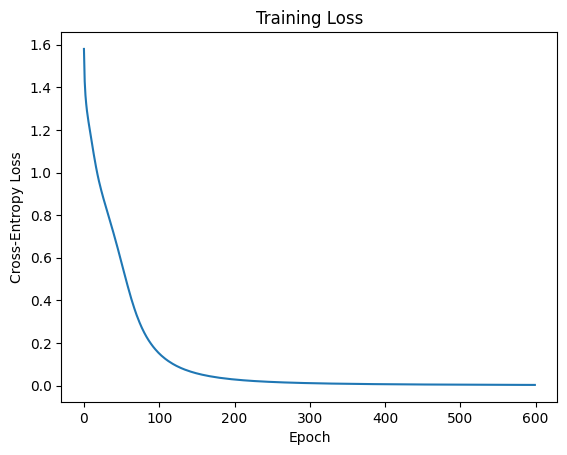

In [55]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss")
plt.show()

In [56]:
pred_test = model.forward(X_test)
pred_labels = np.argmax(pred_test, axis=1) + 1

acc = np.mean(pred_labels == y_test)
print("Test accuracy:", acc)

Test accuracy: 1.0


In [57]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred_labels, labels=[1,2,3,4,5], zero_division=0)
for c in range(1,6):
    print(f"Class {c}: precision={prec[c-1]:.3f}, recall={rec[c-1]:.3f}, f1={f1[c-1]:.3f}")

Class 1: precision=1.000, recall=1.000, f1=1.000
Class 2: precision=1.000, recall=1.000, f1=1.000
Class 3: precision=1.000, recall=1.000, f1=1.000
Class 4: precision=1.000, recall=1.000, f1=1.000
Class 5: precision=1.000, recall=1.000, f1=1.000


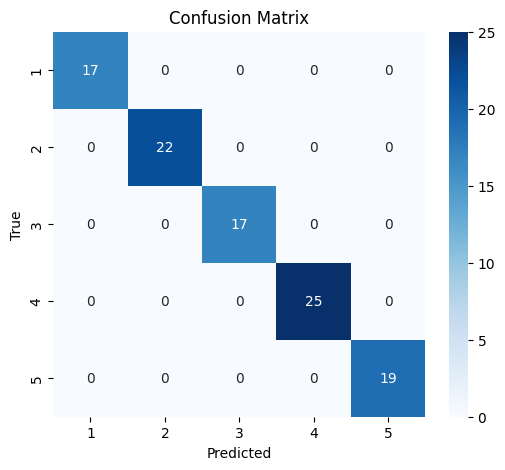

In [58]:
cm = confusion_matrix(y_test, pred_labels, labels=[1,2,3,4,5])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [59]:
y_test_bin = label_binarize(y_test, classes=[1,2,3,4,5])
try:
    auc = roc_auc_score(y_test_bin, pred_test, average=None)
    print("Per-class ROC AUC:", auc)
except Exception as e:
    print("ROC AUC could not be computed:", e)

Per-class ROC AUC: [1. 1. 1. 1. 1.]


In [60]:
# Predict probabilities for a given fetcher
sample = np.array([[25, 10]])

sample = (sample - mean) / std

prediction = model.forward(sample)

print("Predicted class:", prediction[0] + 1)

Predicted class: [1.0109982  1.97118047 1.         1.01781473 1.0000066 ]


In [61]:
# Predict class for a given fetcher
sample = np.array([[40, 30]])

sample = (sample - mean) / std

prediction = model.predict(sample)

print("Predicted class:", prediction[0] + 1)

Predicted class: 5


class
1    100
2    100
3    100
4    100
5    100
Name: count, dtype: int64


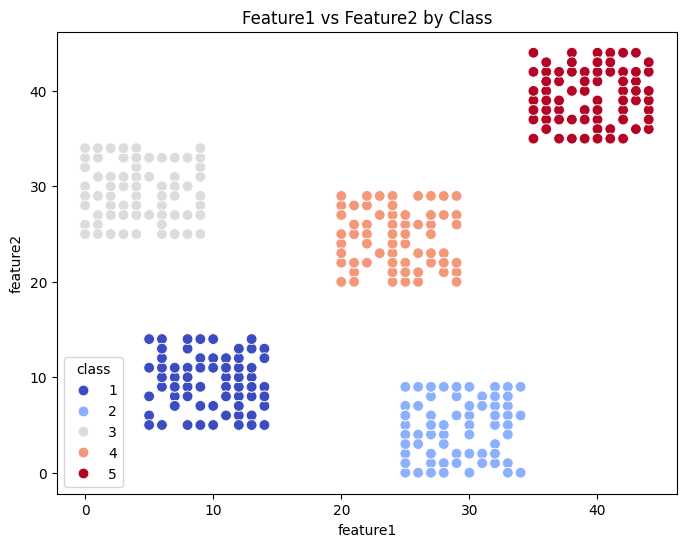

In [62]:
# Visualize all data from dataset
import seaborn as sns

print(df['class'].value_counts())

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="feature1",
    y="feature2",
    hue="class",
    palette="coolwarm",
    s=60
)
plt.title("Feature1 vs Feature2 by Class")
plt.show()

# Modifications for Multi-Class Classification:
The original neural network was adapted to handle 5-class classification by using one-hot encoding for target labels (Y = np.eye(num_classes)[y - 1]) and applying the softmax activation function in the output layer. Cross-entropy loss was used to optimize predictions, and the network architecture was expanded to include three hidden layers with ReLU activations to capture complex patterns in the dataset. Data normalization was applied to improve training stability.

# Challenges and Solutions:
Using sigmoid we can find probability and output between 0 to 1. But using relu and softmax we can enhance the accuracy and find probability for all 5 class. The main challenge was ensuring numerical stability in the softmax and cross-entropy calculations, which was addressed by subtracting the maximum logit value and adding a small epsilon in logarithms. Another challenge was potential overfitting due to perfect accuracy; careful shuffling and batch training were used to minimize this risk.

# Conclusion:
The model achieved perfect training and test accuracy, indicating strong learning on the synthetic dataset. The confusion matrix and per-class metrics confirmed that all classes were correctly predicted. Key lessons include the importance of proper data preprocessing, stable numerical operations, and monitoring for overfitting. Future improvements could include regularization techniques, more diverse datasets, or experimentation with different hidden layer sizes and learning rates to enhance generalization for more complex real-world tasks